In [1]:
# Complete Experiment Script
# --------------------------

# Part 1: Imports and Setup
# --------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time
from tqdm import tqdm  # For progress bars

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Part 2: Data Preparation
# ------------------------

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)

# Create a single data loader with shuffling disabled
batch_size = 640
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

# Load test data
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Part 3: Model Definition
# ------------------------

# Define a simple fully connected neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to initialize a fresh model
def initialize_model():
    return SimpleNet().to(device)

# Part 4: Utility Functions
# -------------------------

# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    cos = torch.nn.functional.cosine_similarity(vec1, vec2, dim=0)
    return cos.item()

# Function to flatten model parameters or gradients into a single vector
def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to print training progress
def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], "
          f"Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Part 5: Adaptive Cosine Similarity Training Loop
# ------------------------------------------------

def train_adaptive_cosine_similarity(model, loader, epochs, desired_cos_sim=-0.6):
    print(f"\nStarting Adaptive Cosine Similarity Training with target: {desired_cos_sim:.2f}...")
    criterion = nn.CrossEntropyLoss()
    model_adaptive = deepcopy(model).to(device)
    
    # Initialize two SGD optimizers with the same hyperparameters
    optimizer1_adaptive = optim.SGD(model_adaptive.parameters(), lr=0.01)
    optimizer2_adaptive = optim.SGD(model_adaptive.parameters(), lr=0.01)
    
    loss_list = []
    cos_sim_list = []
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_adaptive.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_adaptive
                optimizer_name = 'Optimizer1'
            else:
                optimizer = optimizer2_adaptive
                optimizer_name = 'Optimizer2'
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_adaptive(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Apply Adaptive Cosine Similarity Adjustment if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_adaptive.parameters()])
                
                # Decompose current_grads into components
                delta1_norm = torch.norm(last_delta1) + 1e-8
                grad_norm = torch.norm(current_grads) + 1e-8
                
                # Projection of current_grads onto delta1
                proj = (current_grads @ last_delta1) / (delta1_norm ** 2) * last_delta1
                # Orthogonal component
                orthogonal = current_grads - proj
                orthogonal_norm = torch.norm(orthogonal) + 1e-8
                
                # Compute adjusted gradients
                adjusted_grads = (desired_cos_sim * grad_norm / delta1_norm) * last_delta1 + \
                                 (np.sqrt(1 - desired_cos_sim ** 2) * grad_norm / orthogonal_norm) * orthogonal
                
                # Assign adjusted gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_adaptive.parameters():
                        num_params = p.numel()
                        p.grad.copy_(adjusted_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nAdaptive Cosine Similarity Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_adaptive, loss_list, cos_sim_list


Using device: cuda


In [3]:
# Part 6: Running Experiments
# ----------------------------

# Number of experiments
num_experiments = 50

# Number of epochs per experiment
epochs = 5

# Initialize list to store results
results = []

# Initialize the base model once to ensure consistency across experiments
base_model = initialize_model()

# Run 50 experiments with random target cosine similarities
for exp in tqdm(range(num_experiments), desc="Running Experiments"):
    # Generate random target cosine similarity between -1.00 and 1.00
    target_cos_sim = np.random.uniform(-1.0, 1.0)
    
    # Initialize a fresh model for this experiment
    model = initialize_model()
    
    # Train the model with adaptive cosine similarity
    model_trained, loss_adaptive, cos_sim_adaptive = train_adaptive_cosine_similarity(
        model, train_loader, epochs=epochs, desired_cos_sim=target_cos_sim
    )
    
    # Ensure there are at least 100 steps to analyze
    if len(cos_sim_adaptive) >= 100:
        last_100_cos_sims = cos_sim_adaptive[-100:]
        last_100_losses = loss_adaptive[-100:]
    else:
        last_100_cos_sims = cos_sim_adaptive
        last_100_losses = loss_adaptive
    
    # Compute averages
    avg_cos_sim = np.mean(last_100_cos_sims) if len(last_100_cos_sims) > 0 else None
    avg_loss = np.mean(last_100_losses) if len(last_100_losses) > 0 else None
    
    # Append the results
    results.append({
        'target_value': round(target_cos_sim, 4),
        'average_cosine_similarity_last_100_steps': round(avg_cos_sim, 4),
        'average_training_loss_last_100_steps': round(avg_loss, 4)
    })


Running Experiments:   0%|          | 0/50 [00:00<?, ?it/s]


Starting Adaptive Cosine Similarity Training with target: 0.43...


Running Experiments:   2%|▏         | 1/50 [01:21<1:06:10, 81.02s/it]

Epoch [5], Iteration [470/470], Loss: 0.4548, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.01 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.21...


Running Experiments:   4%|▍         | 2/50 [02:42<1:05:09, 81.45s/it]

Epoch [5], Iteration [470/470], Loss: 0.3931, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.74 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.09...


Running Experiments:   6%|▌         | 3/50 [04:01<1:02:56, 80.35s/it]

Epoch [5], Iteration [470/470], Loss: 0.3563, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.03 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.15...


Running Experiments:   8%|▊         | 4/50 [05:21<1:01:15, 79.90s/it]

Epoch [5], Iteration [470/470], Loss: 0.3482, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.20 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.29...


Running Experiments:  10%|█         | 5/50 [06:39<59:29, 79.32s/it]  

Epoch [5], Iteration [470/470], Loss: 0.3994, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.29 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.12...


Running Experiments:  12%|█▏        | 6/50 [07:57<57:55, 78.98s/it]

Epoch [5], Iteration [470/470], Loss: 0.3292, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.31 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.78...


Running Experiments:  14%|█▍        | 7/50 [09:17<56:49, 79.29s/it]

Epoch [5], Iteration [470/470], Loss: 0.8725, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.93 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.93...


Running Experiments:  16%|█▌        | 8/50 [10:37<55:43, 79.61s/it]

Epoch [5], Iteration [470/470], Loss: 1.4370, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.28 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.23...


Running Experiments:  18%|█▊        | 9/50 [11:57<54:29, 79.73s/it]

Epoch [5], Iteration [470/470], Loss: 0.3346, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.00 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.58...


Running Experiments:  20%|██        | 10/50 [13:16<52:51, 79.30s/it]

Epoch [5], Iteration [470/470], Loss: 0.5434, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.31 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.06...


Running Experiments:  22%|██▏       | 11/50 [14:34<51:20, 78.99s/it]

Epoch [5], Iteration [470/470], Loss: 0.3560, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.30 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.14...


Running Experiments:  24%|██▍       | 12/50 [15:52<49:51, 78.72s/it]

Epoch [5], Iteration [470/470], Loss: 0.3720, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.10 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.85...


Running Experiments:  26%|██▌       | 13/50 [17:12<48:45, 79.08s/it]

Epoch [5], Iteration [470/470], Loss: 1.0521, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.89 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.86...


Running Experiments:  28%|██▊       | 14/50 [18:34<48:00, 80.00s/it]

Epoch [5], Iteration [470/470], Loss: 0.3201, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 82.12 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.83...


Running Experiments:  30%|███       | 15/50 [19:55<46:50, 80.30s/it]

Epoch [5], Iteration [470/470], Loss: 0.3141, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.98 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.96...


Running Experiments:  32%|███▏      | 16/50 [21:16<45:40, 80.60s/it]

Epoch [5], Iteration [470/470], Loss: 0.3214, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.31 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.67...


Running Experiments:  34%|███▍      | 17/50 [22:36<44:11, 80.36s/it]

Epoch [5], Iteration [470/470], Loss: 0.6127, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.78 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.56...


Running Experiments:  36%|███▌      | 18/50 [23:58<43:02, 80.72s/it]

Epoch [5], Iteration [470/470], Loss: 0.5089, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.54 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.74...


Running Experiments:  38%|███▊      | 19/50 [25:18<41:40, 80.67s/it]

Epoch [5], Iteration [470/470], Loss: 0.7306, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.55 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.96...


Running Experiments:  40%|████      | 20/50 [26:39<40:20, 80.69s/it]

Epoch [5], Iteration [470/470], Loss: 1.6437, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.72 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.60...


Running Experiments:  42%|████▏     | 21/50 [27:58<38:42, 80.07s/it]

Epoch [5], Iteration [470/470], Loss: 0.5407, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.63 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.08...


Running Experiments:  44%|████▍     | 22/50 [29:18<37:25, 80.18s/it]

Epoch [5], Iteration [470/470], Loss: 0.3446, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.42 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.56...


Running Experiments:  46%|████▌     | 23/50 [30:40<36:16, 80.61s/it]

Epoch [5], Iteration [470/470], Loss: 0.5218, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.61 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.76...


Running Experiments:  48%|████▊     | 24/50 [32:00<34:54, 80.56s/it]

Epoch [5], Iteration [470/470], Loss: 0.3157, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.42 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.28...


Running Experiments:  50%|█████     | 25/50 [33:21<33:34, 80.58s/it]

Epoch [5], Iteration [470/470], Loss: 0.3997, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.62 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.71...


Running Experiments:  52%|█████▏    | 26/50 [34:40<32:05, 80.21s/it]

Epoch [5], Iteration [470/470], Loss: 0.3179, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.34 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.89...


Running Experiments:  54%|█████▍    | 27/50 [35:58<30:29, 79.53s/it]

Epoch [5], Iteration [470/470], Loss: 1.2260, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 77.94 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.04...


Running Experiments:  56%|█████▌    | 28/50 [37:16<29:00, 79.10s/it]

Epoch [5], Iteration [470/470], Loss: 0.3589, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.08 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.17...


Running Experiments:  58%|█████▊    | 29/50 [38:35<27:36, 78.88s/it]

Epoch [5], Iteration [470/470], Loss: 0.3433, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.36 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.47...


Running Experiments:  60%|██████    | 30/50 [39:55<26:26, 79.33s/it]

Epoch [5], Iteration [470/470], Loss: 0.3169, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.38 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.55...


Running Experiments:  62%|██████▏   | 31/50 [41:15<25:08, 79.41s/it]

Epoch [5], Iteration [470/470], Loss: 0.4922, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.57 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.09...


Running Experiments:  64%|██████▍   | 32/50 [42:34<23:48, 79.35s/it]

Epoch [5], Iteration [470/470], Loss: 0.3424, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.21 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.14...


Running Experiments:  66%|██████▌   | 33/50 [43:53<22:28, 79.35s/it]

Epoch [5], Iteration [470/470], Loss: 0.3793, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.35 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.96...


Running Experiments:  68%|██████▊   | 34/50 [45:12<21:08, 79.25s/it]

Epoch [5], Iteration [470/470], Loss: 0.3295, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.01 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.24...


Running Experiments:  70%|███████   | 35/50 [46:31<19:45, 79.03s/it]

Epoch [5], Iteration [470/470], Loss: 0.3854, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.51 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.22...


Running Experiments:  72%|███████▏  | 36/50 [47:49<18:25, 78.97s/it]

Epoch [5], Iteration [470/470], Loss: 0.3858, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.81 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.23...


Running Experiments:  74%|███████▍  | 37/50 [49:11<17:17, 79.84s/it]

Epoch [5], Iteration [470/470], Loss: 0.3778, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.85 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.89...


Running Experiments:  76%|███████▌  | 38/50 [50:31<15:59, 79.93s/it]

Epoch [5], Iteration [470/470], Loss: 1.1993, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 80.14 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.36...


Running Experiments:  78%|███████▊  | 39/50 [51:50<14:33, 79.41s/it]

Epoch [5], Iteration [470/470], Loss: 0.4283, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.21 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.28...


Running Experiments:  80%|████████  | 40/50 [53:09<13:13, 79.32s/it]

Epoch [5], Iteration [470/470], Loss: 0.3341, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.10 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.13...


Running Experiments:  82%|████████▏ | 41/50 [54:28<11:53, 79.24s/it]

Epoch [5], Iteration [470/470], Loss: 0.3430, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.05 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.40...


Running Experiments:  84%|████████▍ | 42/50 [55:47<10:32, 79.09s/it]

Epoch [5], Iteration [470/470], Loss: 0.4353, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.73 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.88...


Running Experiments:  86%|████████▌ | 43/50 [57:09<09:20, 80.14s/it]

Epoch [5], Iteration [470/470], Loss: 0.3206, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 82.57 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.33...


Running Experiments:  88%|████████▊ | 44/50 [58:29<07:59, 79.91s/it]

Epoch [5], Iteration [470/470], Loss: 0.4113, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 79.38 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.34...


Running Experiments:  90%|█████████ | 45/50 [59:50<06:42, 80.49s/it]

Epoch [5], Iteration [470/470], Loss: 0.4266, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.83 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.58...


Running Experiments:  92%|█████████▏| 46/50 [1:01:09<05:19, 79.99s/it]

Epoch [5], Iteration [470/470], Loss: 0.3247, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.80 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.74...


Running Experiments:  94%|█████████▍| 47/50 [1:02:30<04:00, 80.32s/it]

Epoch [5], Iteration [470/470], Loss: 0.3170, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 81.10 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.37...


Running Experiments:  96%|█████████▌| 48/50 [1:03:49<02:39, 79.88s/it]

Epoch [5], Iteration [470/470], Loss: 0.3292, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.84 seconds.


Starting Adaptive Cosine Similarity Training with target: -0.27...


Running Experiments:  98%|█████████▊| 49/50 [1:05:08<01:19, 79.56s/it]

Epoch [5], Iteration [470/470], Loss: 0.3314, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.81 seconds.


Starting Adaptive Cosine Similarity Training with target: 0.14...


Running Experiments: 100%|██████████| 50/50 [1:06:27<00:00, 79.74s/it]

Epoch [5], Iteration [470/470], Loss: 0.3689, Optimizer: Optimizer2
Adaptive Cosine Similarity Training Completed in 78.53 seconds.




Final Results Table:
    target_value  average_cosine_similarity_last_100_steps  \
0         0.4304                                   -0.1774   
1         0.2055                                   -0.0339   
2         0.0898                                    0.0286   
3        -0.1527                                    0.1463   
4         0.2918                                   -0.0870   
5        -0.1248                                    0.1284   
6         0.7835                                   -0.5837   
7         0.9273                                   -0.7990   
8        -0.2331                                    0.1786   
9         0.5835                                   -0.3108   
10        0.0578                                    0.0460   
11        0.1361                                    0.0012   
12        0.8512                                   -0.6822   
13       -0.8579                                    0.4741   
14       -0.8257                                

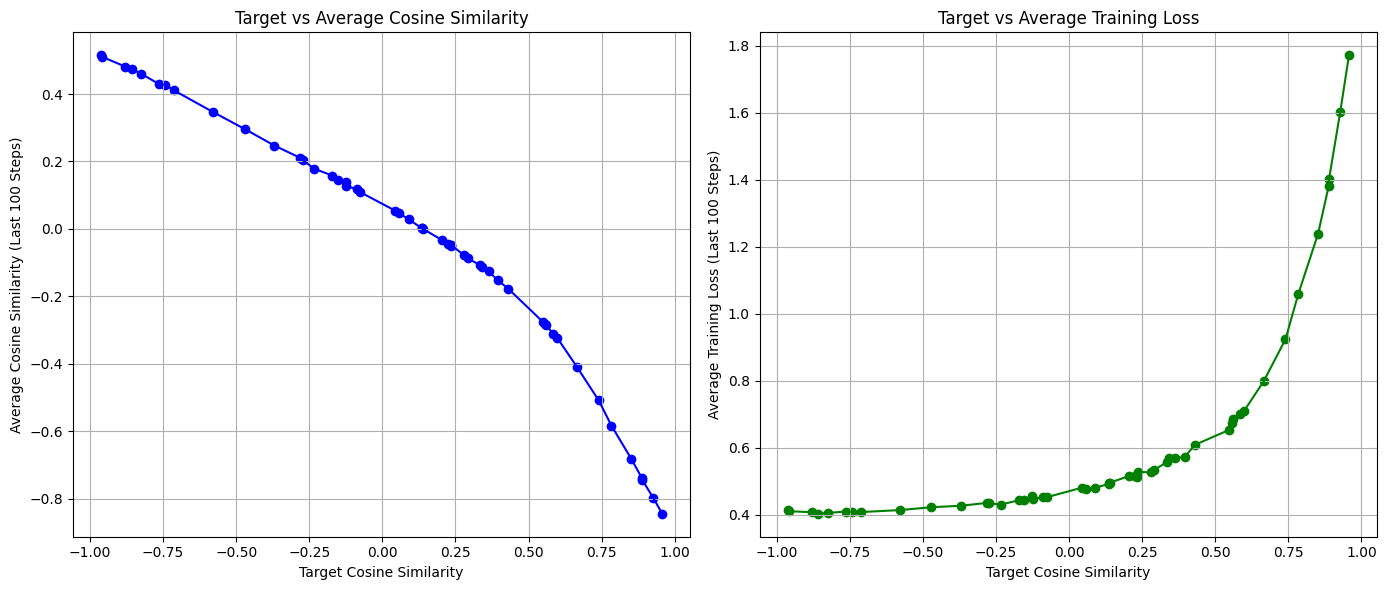

In [6]:
# Part 8: Visualization
# ---------------------

# Ensure 'results' list exists and create the dataframe if not created earlier
if 'df_results' not in globals():
    df_results = pd.DataFrame(results)

# Display the final table
print("\nFinal Results Table:")
print(df_results)

# Sort the dataframe by target_value for plotting
df_sorted = df_results.sort_values(by='target_value')

# Plotting
plt.figure(figsize=(14, 6))

# Subplot 1: Target vs Average Cosine Similarity
plt.subplot(1, 2, 1)
plt.scatter(df_sorted['target_value'], df_sorted['average_cosine_similarity_last_100_steps'], color='blue')
plt.plot(df_sorted['target_value'], df_sorted['average_cosine_similarity_last_100_steps'], linestyle='-', color='blue')
plt.xlabel('Target Cosine Similarity')
plt.ylabel('Average Cosine Similarity (Last 100 Steps)')
plt.title('Target vs Average Cosine Similarity')
plt.grid(True)

# Subplot 2: Target vs Average Training Loss
plt.subplot(1, 2, 2)
plt.scatter(df_sorted['target_value'], df_sorted['average_training_loss_last_100_steps'], color='green')
plt.plot(df_sorted['target_value'], df_sorted['average_training_loss_last_100_steps'], linestyle='-', color='green')
plt.xlabel('Target Cosine Similarity')
plt.ylabel('Average Training Loss (Last 100 Steps)')
plt.title('Target vs Average Training Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Part 1: Imports and Setup
# --------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Part 2: Data Preparation
# ------------------------

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST training dataset
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)

# Create a single data loader with shuffling
batch_size = 640
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

# Load test data
test_dataset = datasets.MNIST('.', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Part 3: Model Definition
# ------------------------

# Define a simple fully connected neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleNet().to(device)

# Part 4: Utility Functions
# -------------------------

# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    cos = torch.nn.functional.cosine_similarity(vec1, vec2, dim=0)
    return cos.item()

# Function to flatten model parameters or gradients into a single vector
def flatten_params(params):
    return torch.cat([p.view(-1) for p in params])

# Function to evaluate the model on the test dataset
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Function to print training progress
def print_progress(epoch, iteration, total_iterations, loss, optimizer_name):
    print(f"Epoch [{epoch+1}], Iteration [{iteration}/{total_iterations}], "
          f"Loss: {loss:.4f}, Optimizer: {optimizer_name}", end='\r')

# Part 5: Adaptive Cosine Similarity Training Loop
# ------------------------------------------------

def train_adaptive_cosine_similarity(model, loader, epochs, desired_cos_sim=-0.6):
    print("\nStarting Adaptive Cosine Similarity Training...")
    criterion = nn.CrossEntropyLoss()
    model_adaptive = deepcopy(model).to(device)
    
    # Initialize two Adam optimizers with the same hyperparameters
    optimizer1_adaptive = optim.Adam(model_adaptive.parameters(), lr=0.001)
    optimizer2_adaptive = optim.Adam(model_adaptive.parameters(), lr=0.001)
    
    loss_list = []
    cos_sim_list = []
    momentum_magnitudes_optimizer1 = []
    momentum_magnitudes_optimizer2 = []
    
    optimizer_updates = {'Optimizer1': [], 'Optimizer2': []}
    total_iterations = len(loader) * epochs
    iteration = 0
    start_time = time.time()
    
    for epoch in range(epochs):
        model_adaptive.train()
        for batch_idx, (data, target) in enumerate(loader):
            iteration += 1
            data, target = data.to(device), target.to(device)
            
            # Determine which optimizer to use
            if batch_idx % 2 == 0:
                optimizer = optimizer1_adaptive
                optimizer_name = 'Optimizer1'
                momentum_tracker = momentum_magnitudes_optimizer1
            else:
                optimizer = optimizer2_adaptive
                optimizer_name = 'Optimizer2'
                momentum_tracker = momentum_magnitudes_optimizer2
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model_adaptive(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            
            # Record parameters before update
            params_before = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Apply Adaptive Cosine Similarity Adjustment if using Optimizer2
            if optimizer_name == 'Optimizer2' and len(optimizer_updates['Optimizer1']) > 0:
                # Get the last update from Optimizer1
                last_delta1 = optimizer_updates['Optimizer1'][-1]
                # Current gradients
                current_grads = flatten_params([p.grad.clone() for p in model_adaptive.parameters()])
                
                # Decompose current gradients
                delta1_norm = torch.norm(last_delta1) + 1e-8
                grad_norm = torch.norm(current_grads) + 1e-8
                
                # Projection of current_grads onto delta1
                proj = (current_grads @ last_delta1) / (delta1_norm ** 2) * last_delta1
                # Orthogonal component
                orthogonal = current_grads - proj
                orthogonal_norm = torch.norm(orthogonal) + 1e-8
                
                # Compute adjusted gradients
                adjusted_grads = (desired_cos_sim * grad_norm / delta1_norm) * last_delta1 + \
                                 (np.sqrt(1 - desired_cos_sim ** 2) * grad_norm / orthogonal_norm) * orthogonal
                
                # Assign adjusted gradients back to model parameters
                with torch.no_grad():
                    idx = 0
                    for p in model_adaptive.parameters():
                        num_params = p.numel()
                        p.grad.copy_(adjusted_grads[idx:idx+num_params].view_as(p))
                        idx += num_params
            
            # Optimizer step
            optimizer.step()
            
            # Record parameters after update
            params_after = flatten_params([p.data.clone() for p in model_adaptive.parameters()])
            
            # Compute delta
            delta = params_after - params_before
            optimizer_updates[optimizer_name].append(delta)
            
            # Compute cosine similarity if both optimizers have at least one update
            if len(optimizer_updates['Optimizer1']) > 0 and len(optimizer_updates['Optimizer2']) > 0:
                latest_delta1 = optimizer_updates['Optimizer1'][-1]
                latest_delta2 = optimizer_updates['Optimizer2'][-1]
                # Ensure both deltas are the same size
                if latest_delta1.shape == latest_delta2.shape:
                    cos_sim = cosine_similarity(latest_delta1, latest_delta2)
                    cos_sim_list.append(cos_sim)
            
            # Track the magnitude of the first moment (momentum) for analysis
            moment_1st_optimizer = [group['exp_avg'] for group in optimizer.param_groups[0]['state'].values()]
            moment_magnitudes = sum([torch.norm(m).item() for m in moment_1st_optimizer])
            momentum_tracker.append(moment_magnitudes)
            
            # Record loss
            loss_list.append(loss.item())
            
            # Print progress every 100 iterations
            if iteration % 100 == 0 or iteration == total_iterations:
                print_progress(epoch, iteration, total_iterations, loss.item(), optimizer_name)
    
    end_time = time.time()
    print(f"\nAdaptive Cosine Similarity Training Completed in {end_time - start_time:.2f} seconds.\n")
    return model_adaptive, loss_list, cos_sim_list, momentum_magnitudes_optimizer1, momentum_magnitudes_optimizer2

# Part 6: Running the Adaptive Training and Analysis
# --------------------------------------------------

# Number of epochs for training
epochs = 5  # Adjust as needed

# Train the model using the adaptive cosine similarity method
desired_cos_sim = 0.  # Desired cosine similarity between -1 and 1
model_adaptive, loss_adaptive, cos_sim_adaptive, momentum_optimizer1, momentum_optimizer2 = train_adaptive_cosine_similarity(
    model, train_loader, epochs=epochs, desired_cos_sim=desired_cos_sim
)

# Function to plot loss curves
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss Curve - Adaptive Cosine Similarity')
    plt.legend()
    plt.show()

# Function to plot cosine similarity
def plot_cosine_similarity(cos_sims):
    plt.figure(figsize=(10, 5))
    plt.plot(cos_sims)
    plt.xlabel('Iteration')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Optimizers - Adaptive Method')
    plt.show()

# Function to plot momentum magnitudes
def plot_momentum(momentum_optimizer1, momentum_optimizer2):
    plt.figure(figsize=(10, 5))
    plt.plot(momentum_optimizer1, label="Optimizer1 Momentum")
    plt.plot(momentum_optimizer2, label="Optimizer2 Momentum")
    plt.xlabel('Iteration')
    plt.ylabel('Momentum Magnitude')
    plt.title('Momentum Magnitudes of Adam Optimizers')
    plt.legend()
    plt.show()

# Plot the loss, cosine similarity, and momentum magnitudes
plot_losses(loss_adaptive)
plot_cosine_similarity(cos_sim_adaptive)
plot_momentum(momentum_optimizer1, momentum_optimizer2)

# Compute and display average loss
avg_loss = np.mean(loss_adaptive)
print(f"Average Loss: {avg_loss:.4f}")

# Compute and display average cosine similarity
if len(cos_sim_adaptive) > 0:
    avg_cos_sim = np.mean(cos_sim_adaptive)
    print(f"Average Cosine Similarity: {avg_cos_sim:.4f}")
else:
    avg_cos_sim = None
    print(f"Average Cosine Similarity: N/A (Insufficient data)")

# Evaluate model on test data
accuracy = evaluate_model(model_adaptive, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")


Using device: cuda

Starting Adaptive Cosine Similarity Training...


KeyError: 'state'